<a href="https://colab.research.google.com/github/anujaprasads/anujashajan/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Flask utils
from flask import Flask, redirect, url_for, request, render_template
from werkzeug.utils import secure_filename
import numpy as np
from glob import glob

In [ ]:
from skimage import transform


In [ ]:
from __future__ import division
import subprocess
import time
from scipy.io import wavfile
import numpy as np
import cv2
import collections
from scipy.ndimage import gaussian_filter1d as gauss

In [ ]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Found existing installation: opencv-python 4.6.0.66
Uninstalling opencv-python-4.6.0.66:
  Successfully uninstalled opencv-python-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement opencv-contrib-python==3.4.2.17 (from versions: 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.14.53, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.2.54, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72)
ERROR: No matching distribution found for opencv-contrib-python==3.4.2.17


Using file --> /content/drive/MyDrive/preprocessingframes/C0008.MP4
processing file: /content/drive/MyDrive/preprocessingframes/C0008.MP4
file /content/drive/MyDrive/preprocessingframes/audio_test.wav saved


Finding STE...: 100%|██████████| 16243200/16243200 [00:53<00:00, 303910.06it/s]


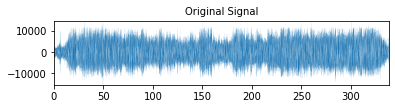

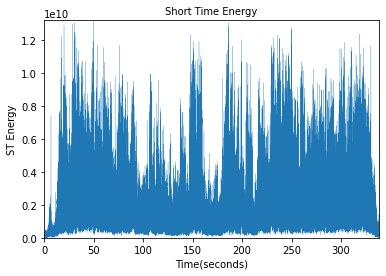

Getting audio cue information...:   0%|          | 0/3511 [00:00<?, ?it/s]<ipython-input-5-9558defec723>:176: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i = np.int(i)
<ipython-input-5-9558defec723>:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for 

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
from __future__ import division
import subprocess
import time
from scipy.io import wavfile
import numpy as np
import cv2
from scipy.signal import find_peaks
from tqdm import tqdm, tnrange
import collections
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d as gauss
#!pip install opencv-contrib-python


def rip_audio(file_dir, op_file_name):
    name = op_file_name
    file_path_input = video_link
    file_path_output = file_dir + '/' + name + '.wav'
    print('processing file: %s' % file_path_input)
    subprocess.call(['ffmpeg', '-i', file_path_input, '-codec:a', 'pcm_s16le', '-ac', '1', file_path_output])
    print('file %s saved' % file_path_output)
    return file_path_output


def getframeatms(ms):
    video = cv2.VideoCapture(video_link)
    video.set(cv2.CAP_PROP_POS_MSEC, ms)
    f_num = video.get(cv2.CAP_PROP_POS_FRAMES)
    ret, frame = video.read()
    return frame, f_num


class BackGroundSubtractor:
    def __init__(self, alpha, firstframe):
        self.alpha = alpha
        self.backGroundModel = firstframe

    def getforeground(self, fram):
        self.backGroundModel = self.backGroundModel * self.alpha + fram * (1 - self.alpha)
        return cv2.absdiff(self.backGroundModel.astype(np.uint8), fram)


def blobdetect(img):
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 3000
    params.maxArea = 70000
    params.filterByColor = True
    params.blobColor = 255
    params.filterByConvexity = False
    params.minConvexity = 0
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(img)
    return keypoints


def denoise(fram):
    fram = cv2.medianBlur(fram, 5)
    fram = cv2.GaussianBlur(fram, (5, 5), 0)
    return fram


def resize(inp):
    height, width, _ = inp.shape
    new_h = np.int(height / 1.5)
    new_w = np.int(width /1.5)
    inp = cv2.resize(inp, (new_w, new_h))
    return inp


def resize_gray(inp):
    height, width = inp.shape
    new_h = np.int(height / 1.5)
    new_w = np.int(width / 1.5)
    inp = cv2.resize(inp, (new_w, new_h))
    return inp


def rgb2gray(inp):
    inp = cv2.cvtColor(inp, cv2.COLOR_BGR2GRAY)
    return inp


def calcParams(point1, point2):  # line's equation Params computation
    if point2[1] - point1[1] == 0:
        a = 0
        b = -1.0
    elif point2[0] - point1[0] == 0:
        a = -1.0
        b = 0
    else:
        a = (point2[1] - point1[1]) / (point2[0] - point1[0])
        b = -1.0

    c = (-a * point1[0]) - b * point1[1]
    return Params(a, b, c)


def areLinesIntersecting(params1, params2, point1, point2):
    det = params1.a * params2.b - params2.a * params1.b
    if det == 0:
        return False  # lines are parallel
    else:
        x = (params2.b * -params1.c - params1.b * -params2.c) / det
        y = (params1.a * -params2.c - params2.a * -params1.c) / det
        if max(point1[0], point2[0]) >= x >= min(point1[0], point2[0]) and max(point1[1], point2[1]) >= y >= min(
                point1[1], point2[1]):
            # print("intersecting in:", x,y)
            # cv2.circle(frame,(int(x),int(y)),4,(0,0,255), -1)  # intersecting point
            return True  # lines are intersecting inside the line segment
        else:
            return False  # lines are intersecting but outside of the line segment


def grayscale(fram):
    frame = cv2.cvtColor(fram, cv2.COLOR_BGR2GRAY)
    return frame


def calclength(frm):
    tim = np.int((frm * 20) / 1000)
    return tim


start = time.time()
Params = collections.namedtuple('Params', ['a', 'b', 'c'])  # to store equation of a line
file_dir = '/content/drive/MyDrive/preprocessingframes'
video_link = '/content/drive/MyDrive/preprocessingframes/C0008.MP4'
# AUDIO PROCESSING #####
print("Using file --> %s" % video_link)
op_file_name = 'audio_test'
aud_file_name = rip_audio(file_dir, op_file_name)

# Calculate Short Time Energy #####
fs, signal = wavfile.read(aud_file_name)
 # fs = sampling freq, signal = input audio file
#signal = signal / max(abs(signal))
 # scaling the signal
fc = 40
a = np.exp(-fc * 2 * np.pi / fs)
STEs = []
for n in tqdm(range(0, len(signal)), desc='Finding STE...'):  # calculating Short time energy
    if n == 0:
        STEs.append(a * 0 + signal[n] ** 2)
    else:
        STEs.append(a * STEs[n - 1] + signal[n] ** 2)

xaxis = np.linspace(0, len(signal) / 48000, num=len(signal))  # scaling down x-axis to show time units
npSTEs = np.asarray(STEs)
#plt.plot(npSTEs)
#plt.show()
peakpoints, _ = find_peaks(npSTEs, distance=2500, prominence=np.mean(npSTEs))
pkintime = peakpoints / 48000
fig = plt.figure()
fig1 = fig.add_subplot(311)
fig1.plot(xaxis, signal,linewidth=0.05 )
plt.title('Original Signal', fontsize=10)
plt.autoscale(tight='both')
plt.show()

fig1 = fig.add_subplot(312)
plt.title('Short Time Energy', fontsize=10)
plt.ylabel('ST Energy')
plt.xlabel('Time(seconds)')
plt.autoscale(tight='both')
# = gauss(npSTEs, sigma=2)
plt.plot(xaxis, STEs, linewidth=.2)
plt.show()
plt.savefig('/content/drive/MyDrive/croptrain/fig.png', dpi=600)

# Audio cue information #####
cam = cv2.VideoCapture(video_link)
framerange = []
cropped_frames = []
for i in tqdm(pkintime, desc='Getting audio cue information...'):
    i = np.int(i)
    limit_l = (i * 1000) - 1400
    limit_h = (i * 1000) + 1400
    timerange = range(limit_l, limit_h, 880)
    for j in timerange:
        cam.set(cv2.CAP_PROP_POS_MSEC, j)
        res, frame = cam.read()
        temp_frame = np.int(cam.get(cv2.CAP_PROP_POS_FRAMES))
        framerange.append(temp_frame)
plt.stem(timerange)
plt.show()
# VIDEO PROCESSING #####
cam = cv2.VideoCapture(video_link)
tot_frames = cam.get(cv2.CAP_PROP_FRAME_COUNT)
ret, frame1 = cam.read()
frame = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)


if ret is True:

    frame = resize_gray(frame)
    backSubtractor = BackGroundSubtractor(0.8, denoise(frame))
    run = True
else:
    run = False
last_centroid = (960, 0)
crop_init = 0
while run:
    ret, frame = cam.read()
    if ret is True:
        #filename = '/content/drive/MyDrive/preprocessingframes/frameout8/%d.jpg'
        #cv2.imwrite(filename,frame)
        frame = resize(frame)
        frame_og = frame
        frame = cv2.GaussianBlur(frame, (5, 5), cv2.BORDER_DEFAULT)
        # Background Subtraction #####
        foreGround = backSubtractor.getforeground(grayscale(denoise(frame)))
        # Morphological Operations #####
        ret, mask = cv2.threshold(foreGround, 15, 255, cv2.THRESH_BINARY)
        mask = denoise(mask)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
        n = 20
        for i in range(1, n):
            img_dilation = cv2.dilate(mask, kernel, iterations=20)
            img_dilation = cv2.GaussianBlur(img_dilation, (9, 9), cv2.BORDER_DEFAULT)
            img_dilation = cv2.morphologyEx(img_dilation, cv2.MORPH_CLOSE, kernel)
            ret3, img_dilation = cv2.threshold(img_dilation, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # BLOB Detection  #####
        keypoints = blobdetect(img_dilation)
        im_with_keypoints = cv2.drawKeypoints(img_dilation, keypoints, np.array([]), (0, 255, 0),
                                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_dilation)
        plt.show()


        # Selection of Good Keypoints #####
        intercept_line_params3 = calcParams((300, 300), (960, 460))
        good_keypoint = (0, 0)
        for i in keypoints:
            x = i.pt[0]
            y = i.pt[1]
            centroid = (x, y)
            line_params = calcParams(last_centroid, centroid)
            if areLinesIntersecting(intercept_line_params3, line_params, last_centroid, centroid):
                good_keypoint = centroid
                flag_kp = True
            else:
                last_centroid = centroid
                flag_kp = False
            if flag_kp:
                break

        # Frame validity check #####
        current_millis = cam.get(cv2.CAP_PROP_POS_MSEC)
        _, current_frameno = getframeatms(current_millis)
        im_with_gd_kpoints = frame
        #if current_frameno in framerange:

            # Drawing Good Keypoints #####
        n_x = np.int(good_keypoint[0] - 150)
        n_y = np.int(good_keypoint[1] - 150)
        if good_keypoint != (0, 0):
             im_with_gd_kpoints = cv2.rectangle(frame, (n_x, n_y), (n_x + 300, n_y + 300), (0, 255, 0), 1)
             crop_kp = frame_og[n_y:(n_y + 300), n_x:(n_x + 300)]
             #plt.imshow(crop_kp)
             #plt.show()

             if crop_kp.size > 0:
                  cropped_frames.append(crop_kp)
                  filename_crop = '/content/drive/MyDrive/preprocessingframes/out6/%d.jpg' % current_frameno

                  cv2.imwrite(filename_crop, crop_kp)

                  #surf = cv2.xfeatures2d.SURF_create(4000, upright=True)
                  #kp, des = surf.detectAndCompute(crop_kp, None)
                    #SURF_kps = cv2.drawKeypoints(crop_kp, kp, None, (0, 0, 255), 4)
                    #cv2.imshow("Keypoints", SURF_kps)
             else:
                 im_with_gd_kpoints = frame_og
        else:
            # current_frameno = getframeatms(current_millis)
        #print("frame {0} rejected\n".format(np.int(current_frameno)))
        #im_with_gd_kpoints = frame_og
           print("{0} sec(s) or {1} min(s) - {2}%".format(calclength(current_frameno),
                                                      np.int(calclength(current_frameno) / 60),
                                                      np.int((current_frameno / tot_frames) * 100)))
else:
   print("{0} sec(s) or {1} min(s) - {2}%".format(calclength(current_frameno),
                                                       np.int(calclength(current_frameno) / 60),
                                                       np.int((current_frameno / tot_frames) * 100)))




cam.release()
cv2.destroyAllWindows()
############################################################
processed = calclength(current_frameno)
print("--- Total time taken - {0} seconds for a {1} sec video---".format(np.int(time.time() - start),
                                                                         np.int(processed)))

In [ ]:

import cv2

# Opens the Video file
cap= cv2.VideoCapture('/content/drive/MyDrive/preprocessingframes/C0008.MP4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    #print(ret)
    if ret == False:
        break
    cv2.imwrite('/content/drive/MyDrive/preprocessingframes/frameout8/'+str(i)+'.jpg',frame)
    i+=1

cap.release()
cv2.destroyAllWindows()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from skimage import transform
import cv2
import matplotlib.pyplot as plt

image ="/content/drive/MyDrive/croptrain/test_yolo/2w/1.jpg"
img=cv2.imread(image)
transform=transform.flip(img,angle=-10,cval=255)
plt.imshow(img)
plt.show()

plt.imshow(transform)
plt.show()


AttributeError: ignored

In [ ]:
currentframe=[]
from __future__ import division
import subprocess
import time
from scipy.io import wavfile
import numpy as np
import cv2
from scipy.signal import find_peaks
from tqdm import tqdm, tnrange
import collections
from scipy.ndimage import gaussian_filter1d as gauss
img1=[]
img2=[]
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import numpy
import os
import glob
mypath='/content/drive/MyDrive/preprocessingframes/out6'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype=object)
print(len(onlyfiles))
for n in range(0, len(onlyfiles)):
  images[n] = cv2.imread( join(mypath,onlyfiles[n]) )
  surf=cv2.xfeatures2d.SURF_create(4000, upright=True)
  img1= images[n]
  kp1, des1 = surf.detectAndCompute(np.asarray(images[n]), None)
  n+=1
  images[n] = cv2.imread( join(mypath,onlyfiles[n]))
  img2= images[n]
  kp2, des2 = surf.detectAndCompute(np.asarray(images[n]), None)
  sub=len(kp1)-len(kp2);
  print(sub)
  #currentframe=1
  if sub >60:
       filename_surf1 = '/content/drive/MyDrive/preprocessingframes/surfoutput6/frame'+str(n)+'.jpg'
       cv2.imwrite(filename_surf1,img1)
       n+=1
       print("frame ACCEPTEDggg")
       filename_surf1 = '/content/drive/MyDrive/preprocessingframes/surfoutput6/frame'+str(n)+'.jpg'
       cv2.imwrite(filename_surf1,img2)
  else:
      if len(kp1)>len(kp2):
           filename_surf1 = '/content/drive/MyDrive/preprocessingframes/surfoutput6/frame'+str(n)+'.jpg'
           cv2.imwrite(filename_surf1,img1)
      else:
          filename_surf1 = '/content/drive/MyDrive/preprocessingframes/surfoutput6/frame'+str(n)+'.jpg'
          cv2.imwrite(filename_surf1,img2)





974
1
11
-6
7
-9
10
-2
0
2
-12
-3
-3
-1
8
19
-1
-1
-1
3
-4
5
-2
2
-46
44
-1
-40
14
-1
6
-1
-3
7
-2
20
0
0
1
-1
0
-8
4
3
2
1
-1
0
2
-1
-1
-6
4
-7
-56
12
55
0
-60
0
30
-2
-1
1
3
-7
1
0
3
25
6
1
-4
-1
3
1
1
0
-6
-7
-6
-4
-1
2
22
-14
14
-12
1
-5
2
0
-1
2
-7
18
-38
-40
66
frame ACCEPTEDggg
3
3
4
0
2
-31
-54
80
frame ACCEPTEDggg
5
-2
-36
19
17
-18
-18
39
1
0
0
0
-5
1
1
-8
11
0
-10
9
0
0
-10
9
2
-1
-1
0
1
0
-7
5
-15
17
-2
2
-1
-3
3
0
1
-2
-3
-3
5
0
2
-1
0
-2
2
3
-1
-1
-26
28
-30
30
-18
17
-21
-3
25
-14
14
-9
2
7
-3
0
1
1
0
1
-2
2
-1
-140
133
frame ACCEPTEDggg
-1
9
0
-10
-2
-1
2
-2
1
-2
1
1
1
0
-2
2
-1
-3
2
2
-5
16
-18
4
1
0
-1
1
13
-17
1
2
2
-2
0
-1
2
-1
14
-15
15
-14
1
0
1
0
0
-4
5
-5
1
0
1
0
-1
-4
2
17
0
0
0
-15
1
0
0
0
-1
0
0
1
1
-3
1
-1
4
-4
4
-3
-3
5
-1
-2
-2
3
-3
1
0
-6
7
0
1
1
-9
1
10
-1
2
0
1
-17
11
-4
2
-13
11
4
-5
12
0
7
-5
4
1
0
0
-16
-1
-61
40
26
4
-1
3
-2
4
2
-7
9
-4
0
0
2
-83
81
frame ACCEPTEDggg
-3
-24
26
5
2
-7
-3
3
1
-1
3
-36
40
-2
0
-19
17
-10
-7
18
-1
-2
-16
-18
24
-4
6
-6


IndexError: ignored

In [ ]:
def getframeatms(ms):
    video = cv2.VideoCapture(video_link)
    video.set(cv2.CAP_PROP_POS_MSEC, ms)
    f_num = video.get(cv2.CAP_PROP_POS_FRAMES)
    ret, frame = video.read()
    #frame = np.array(frame, dtype=np.uint8)
    return frame, f_num


class BackGroundSubtractor:
    def __init__(self, alpha, firstframe):
        #frame = np.array(frame, dtype=np.uint8)
        self.alpha = alpha
        self.backGroundModel = firstframe

    def getforeground(self, frame):
        #frame = np.array(frame, dtype=np.uint8)
        self.backGroundModel = self.backGroundModel * self.alpha + frame * (1 - self.alpha)
        #frame = np.array(frame, dtype=np.uint8)
        return cv2.absdiff(self.backGroundModel.astype(np.uint8), frame)


def blobdetect(img):
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 3000
    params.maxArea = 70000
    params.filterByColor = True
    params.blobColor = 255
    params.filterByConvexity = False
    params.minConvexity = 0
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(img)
    return keypoints


def denoise(frame):
    frame = cv2.medianBlur(frame, 5)
    frame = cv2.GaussianBlur(frame, (5, 5), 0)
    #frame = np.array(frame, dtype=np.uint8)
    return frame


def resize(inp):
    height, width, _ = inp.shape
    new_h = np.int(height / 2)
    new_w = np.int(width / 2)
    inp = cv2.resize(inp, (new_w, new_h))
    return inp


def resize_gray(inp):
    height, width = inp.shape
    new_h = np.int(height / 2)
    new_w = np.int(width / 2)
    inp = cv2.resize(inp, (new_w, new_h))
    return inp


def rgb2gray(inp):
    inp = cv2.cvtColor(inp, cv2.COLOR_BGR2GRAY)
    return rgb2gray(inp)


def calcParams(point1, point2):  # line's equation Params computation
    if point2[1] - point1[1] == 0:
        a = 0
        b = -1.0
    elif point2[0] - point1[0] == 0:
        a = -1.0
        b = 0
    else:
        a = (point2[1] - point1[1]) / (point2[0] - point1[0])
        b = -1.0

    c = (-a * point1[0]) - b * point1[1]
    return Params(a, b, c)


def areLinesIntersecting(params1, params2, point1, point2):
    det = params1.a * params2.b - params2.a * params1.b
    if det == 0:
        return False  # lines are parallel
    else:
        x = (params2.b * -params1.c - params1.b * -params2.c) / det
        y = (params1.a * -params2.c - params2.a * -params1.c) / det
        if max(point1[0], point2[0]) >= x >= min(point1[0], point2[0]) and max(point1[1], point2[1]) >= y >= min(
                point1[1], point2[1]):
            # print("intersecting in:", x,y)
            # cv2.circle(frame,(int(x),int(y)),4,(0,0,255), -1)  # intersecting point
            return True  # lines are intersecting inside the line segment
        else:
            return False  # lines are intersecting but outside of the line segment


def grayscale(frame):
    #frame = np.array(frame, dtype=np.uint8)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #frame = np.array(frame, dtype=np.uint8)
    return grayscale(frame)


def calclength(frm):
    tim = np.int((frm * 20) / 1000)
    return tim


start = time.time()
Params = collections.namedtuple('Params', ['a', 'b', 'c'])  # to store equation of a line
file_dir = '/content/drive/MyDrive/preprocessingframes/'
video_link = '/content/drive/MyDrive/preprocessingframes/C0002.MP4'
# AUDIO PROCESSING #####

# Audio cue information #####
currentframe=0
cropped_frames = []
# VIDEO PROCESSING #####
cam = cv2.VideoCapture(video_link)

#
print("true")
while(True):
#tot_frames = cam.get(cv2.CAP_PROP_FRAME_COUNT)
    ret, frame = cam.read()


    #frame = np.array(frame, dtype=np.uint8)

    #frame = np.array(frame, dtype=np.uint8)
#frame = np.array(frame, dtype=np.uint8)
    if ret is True:
        name='/content/drive/MyDrive/preprocessingframes/framec0002moving/frame'+str(currentframe)+'.jpg'
        #cv2.imwrite(name,frame)
        print("frames")
        #frame = np.array(frame, dtype=np.uint8)
        currentframe+=1
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = resize_gray(frame)
        backSubtractor = BackGroundSubtractor(0.8, denoise(frame))
        run = True
    else:
       run = False
last_centroid = (960, 0)
crop_init = 0
while run:
    ret, frame = cam.read()
    #frame = np.array(frame, dtype=np.uint8)
    if ret is True:

        frame = resize(frame)
        frame = np.array(frame, dtype=np.uint8)
        frame_og = frame
        frame = np.array(frame, dtype=np.uint8)
        frame = cv2.GaussianBlur(frame, (5, 5), cv2.BORDER_DEFAULT)
        # Background Subtraction #####
        foreGround = backSubtractor.getforeground(grayscale(denoise(frame)))
        # Morphological Operations #####
        ret, mask = cv2.threshold(foreGround, 15, 255, cv2.THRESH_BINARY)
        mask = denoise(mask)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
        n = 20
        for i in range(1, n):
            img_dilation = cv2.dilate(mask, kernel, iterations=20)
            img_dilation = cv2.GaussianBlur(img_dilation, (9, 9), cv2.BORDER_DEFAULT)
            img_dilation = cv2.morphologyEx(img_dilation, cv2.MORPH_CLOSE, kernel)
            ret3, img_dilation = cv2.threshold(img_dilation, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # BLOB Detection  #####
        keypoints = blobdetect(img_dilation)
        im_with_keypoints = cv2.drawKeypoints(img_dilation, keypoints, np.array([]), (0, 255, 0),
                                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        # Selection of Good Keypoints #####
        intercept_line_params3 = calcParams((300, 300), (960, 460))
        good_keypoint = (0, 0)
        for i in keypoints:
            x = i.pt[0]
            y = i.pt[1]
            centroid = (x, y)
            line_params = calcParams(last_centroid, centroid)
            if areLinesIntersecting(intercept_line_params3, line_params, last_centroid, centroid):
                good_keypoint = centroid
                flag_kp = True
            else:
                last_centroid = centroid
                flag_kp = False
            if flag_kp:
                break
# Frame validity check #####
        current_millis = cam.get(cv2.CAP_PROP_POS_MSEC)
        _, current_frameno = getframeatms(current_millis)
        im_with_gd_kpoints = frame
        #if current_frameno in framerange:
        print("frame {0} ACCEPTED\n")
            # Drawing Good Keypoints #####
        n_x = np.int(good_keypoint[0] - 150)
        n_y = np.int(good_keypoint[1] - 150)
        if good_keypoint != (0, 0):
           im_with_gd_kpoints = cv2.rectangle(frame, (n_x, n_y), (n_x + 300, n_y + 300), (0, 255, 0), 1)
           crop_kp = frame_og[n_y:(n_y + 300), n_x:(n_x + 300)]
           if crop_kp.size > 0:
              cropped_frames.append(crop_kp)
              #filename_crop = '/content/drive/MyDrive/preprocessingframes/'\
                                'out/%d.jpg' % current_frameno
              #cv2.imwrite(filename_crop, crop_kp)
              surf = cv2.xfeatures2d.SURF_create(4000, upright=True)
              kp, des = surf.detectAndCompute(crop_kp, None)
              SURF_kps = cv2.drawKeypoints(crop_kp, kp, None, (0, 0, 255), 4)
              cv2.imshow("Keypoints", SURF_kps)
           else:
               im_with_gd_kpoints = frame_og

        #print("{0} sec(s) or {1} min(s) - {2}%".format(calclength(current_frameno),
                                                       #np.int(calclength(current_frameno) / 60),
                                                       #np.int((current_frameno / tot_frames) * 100)))
        # Demarcation line #####
        im_with_gd_kpoints = cv2.line(im_with_gd_kpoints, (300, 300), (960, 460), (0, 0, 255), 2)
        filename_crop = '/content/drive/MyDrive/preprocessingframes/'\
                                'out/%d.jpg' % current_frameno
        cv2.imwrite(filename_crop, im_with_gd_kpoints)
        #cv2.imshow("filtered result", im_with_gd_kpoints)
        # cv2.imshow("Blobs", im_with_keypoints[270:540, 320:960])

        key = cv2.waitKey(10) & 0xFF
    else:
        #print("{0} sec(s) or {1} min(s) - {2}%".format(calclength(current_frameno),
         #                                              np.int(calclength(current_frameno) / 60),
         #                                              np.int((current_frameno / tot_frames) * 100)))
        break

    #if key == 27:
     #   print("{0} sec(s) or {1} min(s) - {2}%".format(calclength(current_frameno),
      #                                                 np.int(calclength(current_frameno) / 60),
       #                                                np.int((current_frameno / tot_frames) * 100)))
        #break

for cropped_frame in cropped_frames:
    if crop_init == 0:
        img1 = cropped_frame
    else:
        img2 = cropped_frame
        surf = cv2.SURF_create(4000, upright=True)
        kp1, des1 = surf.detectAndCompute(img1, None)
        kp2, des2 = surf.detectAndCompute(img2, None)
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = bf.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)
        img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, flags=2)
        #cv2.imshow("Matches", img3)

cam.release()
cv2.destroyAllWindows()
############################################################
processed = calclength(current_frameno)
#print("--- Total time taken - {0} seconds for a {1} sec video---".format(np.int(time.time() - start),
 #                                                                        np.int(processed)))S

Streaming output truncated to the last 5000 lines.
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
frames
fram

KeyboardInterrupt: ignored

In [ ]:
import cv2

vc = cv2.VideoCapture('/content/drive/MyDrive/preprocessingframes/C0002.MP4')

currentframe = 0

while(True):

    # reading from frame
    ret,frame = vc.read()

    if ret:
        # if video is still left continue creating images
        name = './content/sample_data/output/frames' + str(currentframe) + '.jpg'
        print ('Creating...' + name)

        # writing the extracted images
        cv2.imwrite(name, frame)

        # increasing counter so that it will
        # show how many frames are created
        currentframe += 1
    else:
        break

# Release all space and windows once done
